In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from collections import Counter

In [3]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
import numba
from itertools import combinations

In [5]:
import pandas as pd
import umap

In [6]:
@numba.njit()
def H_alpha_sparse_csr(arr_p,alpha=1.0):
    '''Calculate generalized entropy of order-alpha
        H_{\alpha}(\vec{p}) = \frac{1}{1-\alpha}( \sum_i p_i^{\alpha} - 1  )
        https://en.wikipedia.org/wiki/Tsallis_entropy

        INPUT:
        - arr_p, array (normalized probability distribution)
        optional
        - alpha, float (default:1.0 == Boltzmann-Shannon-Gibbs entropy)
        OUT:
        - H_alpha, float

        Note that we have to consider special cases 
        - alpha=0; if p_i=0: p_i^0=0 and p_i>0: p_i^0=1  
        - alpha=1; H --> -\sum_i p_i log(p_i) and 0*log(0) = 0
    '''
    ## consider only entries with p>0
    arr_p_pos = arr_p
    H = 0.0
    if alpha == 0.0:
        H = len(arr_p_pos) - 1
    elif alpha == 1.0:
        H = -np.sum(arr_p_pos*np.log(arr_p_pos))
    else:
        H = 1.0/(1.0-alpha)*(np.sum(arr_p_pos**alpha) - 1.0)
    return H

def D_alpha_sparse_csr(arr_p1, arr_p2, alpha=2.0,pi1=0.5,normalized=True):
    '''
    Generalized Jensen-Shannon divergence proposed in:
        Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
        https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    quantifying the divergence between probability distributions p1 and p2

    INPUT:
    - p1, array  
    - p2, array
    optional
    - alpha, float (default:1)
    - pi1, float (default:0.5); weight given to p1 (pi2 = 1-pi1)
    - normalized (default:False); if True return normalized version of alpha-JSD

    OUTPUT:
    - JSD, float

    Note that p1 and p2 have to be defined over the SAME support, i.e.
    for any index i the probabilities p1[i] and p2[i] refer to the same symbol.
    If, for example a symbol j only appears in p1, then p1[j]>0 and p2[j]=0 (and vice versa)
    '''

    pi2 = 1.0-pi1

    H_1 = H_alpha_sparse_csr(arr_p1.data,alpha=alpha)
    H_2 = H_alpha_sparse_csr(arr_p2.data,alpha=alpha)
    arr_p12 = pi1*arr_p1 + pi2*arr_p2
    H_12 = H_alpha_sparse_csr(arr_p12.data,alpha=alpha)

    D = H_12 - pi1*H_1 - pi2*H_2

    if normalized == False:
        norm = 1.0
    else:
        norm = D_alpha_max(H_1,H_2,pi1,pi2,alpha=alpha)
    D /= norm
    return D

@numba.njit()
def D_alpha_max(H1,H2,pi1,pi2,alpha=1.0):
    '''The maximum Jensen-Shanon-divergence of two probability distributions p1 and p2
    with entropies H1 and H2 and weights pi1 and pi2.
    The maximum jsd is obtained by assuming the support of both distributions is disjunct.
    For more information see:
    Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
    https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    INPUT:
    - H1, float, alpha-entropy of p1
    - H2, float, alpha-entropy of p2
    - pi1, float, weight given to p1
    - pi2, float, weight given to p2
    optional
    - alpha, float (default:1.0)

    OUTPUT:
    - D_max, float - maximum JSD
    '''
    D_max = 0.0
    if alpha == 1.0:
        D_max = -pi1*np.log(pi1)-pi2*np.log(pi2)
    else:
        D_max = (pi1**alpha-pi1)*H1+\
                (pi2**alpha-pi2)*H2+\
                1.0/(1.0-alpha)*(pi1**alpha+pi2**alpha-1)
    return D_max


In [445]:
_x = pd.read_pickle("../../pytorch-transformers/examples/gpt2-gutenberg-prompts.p")

In [446]:
_x[0]

{'model': 'gpt2',
 'input': 'escaped from the pinnace, keeping the lady as before.\n\n“Well, sirs, we waited five days, having made houses of boughs as\nbefore, without hearing aught; and on the sixth we saw coming afar off\nMr. Oxenham, and with him fifteen or twenty men, who seemed very weary\nand wounded; and when we looked for t',
 'output': 'zentzter put them, and they found themselves in one end of the hatches, and\n\nfragmental digging into the facades of the roof, like two large bones,\n\nwhile the sepulcher was taken of them. The inflammation of bone behind the neck,\n\nwhich turned thick and appeared to be affected by the winds of the storm, as far as the west of Israel\n\nand Galilee, was upon the glorious white head, forming part of his armor. He comes and\n\n\n33 I read [see Joseph] says:\n\n"I give the mother of Abraham six cubits each of each well-knowed man in the earth, wherein is for an\n\nodyssey of deep Sustenance to the Mayan Times; from which passage the seclusion

In [345]:
train_texts = []
train_labels = []

In [414]:
for x in _x:
    xin = x["input"]
    xout = x["output"]
    m = min(len(xin), len(xout))
    train_texts.append(xin[:m])
    train_labels.append(0)
    train_texts.append(xout[:m])
    train_labels.append(1)
    break

In [447]:
import pathlib

In [452]:
x = _x[1]

In [455]:
pgsource = pathlib.Path("../../gutenberg/data/text/") / x["PGID"]

In [454]:
pgsource.read_text()

FileNotFoundError: [Errno 2] No such file or directory: '../../gutenberg/data/text/PG1377_text.txt'

In [378]:
texts = []
labels = []
for text, label in zip(train_texts, train_labels):
#    if len(text) > 0 and Counter(text.split(" ")).most_common()[0][0] == "the":
#        if label == 0 or np.random.uniform() < 0.1:
    texts.append(text)
    labels.append(label)

In [379]:
len(texts)

474

In [380]:
Counter(labels)

Counter({0: 237, 1: 237})

In [381]:
vect = CountVectorizer()

In [382]:
M = vect.fit_transform(texts)

In [383]:
MM = M.toarray()

In [384]:
from sklearn.decomposition import PCA

In [394]:
num_docs = M.shape[0]
D = np.empty(shape=(num_docs, num_docs))

for i0, i1 in combinations(range(num_docs), 2):
    _d = D_alpha_sparse_csr(M[i0], M[i1], alpha=1.01)
    D[i0, i1] = _d
    D[i1, i0] = _d

In [395]:
D = pd.DataFrame(D).replace(-np.inf, np.nan).fillna(0).values

In [400]:
proj = umap.UMAP(metric="precomputed")
proj = umap.UMAP()
proj = TSNE()
proj = PCA(n_components=2)

In [401]:
x, y = proj.fit_transform(MM).T

Text(0.5, 1.0, '')

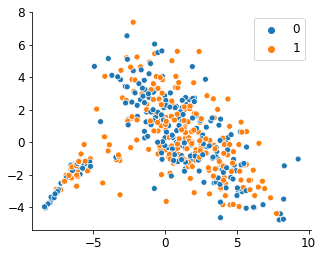

In [402]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(x, y, hue=labels)
ax.set_title("")
#ax.set_xlim(-30, -18)
#ax.set_ylim(-6, 0)

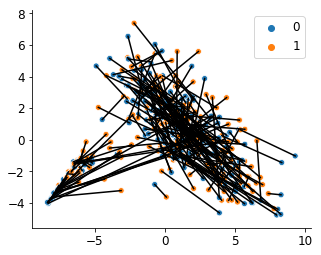

In [403]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
x0 = x[0::2]
x1 = x[1::2]
y0 = y[0::2]
y1 = y[1::2]
for _x0, _x1, _y0, _y1 in zip(x0, x1, y0, y1):
    ax.plot([_x0, _x1], [_y0, _y1], color="black")
sns.scatterplot(x, y, hue=labels)


In [404]:
import itertools

In [405]:
dists = []
cats = []
for i, j in itertools.combinations(range(num_docs), r=2):
    dists.append(D[i, j])
    if j == i + 1 and i%2 == 0:
        cats.append("in2out")
    elif i%2 == 0:
        cats.append("in2in")
    else:
        cats.append("out2out")

In [406]:
df = pd.DataFrame([dists, cats], index=["JSD", "kind"]).T
df["JSD"] = df.JSD.astype(float)


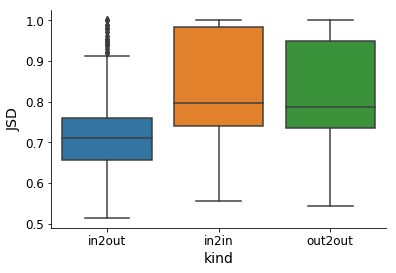

In [408]:
sns.boxplot(data=df, x="kind", y="JSD")

In [167]:
proj = TSNE()

In [168]:
x, y = proj.fit_transform(MM).T

Text(0, 0.5, 'TSNE1')

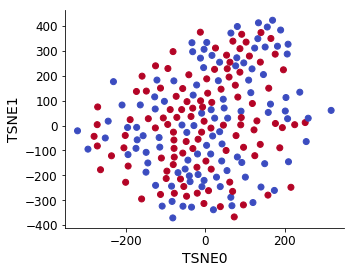

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(
    x, y,
    c=labels,
    cmap="coolwarm"
)
ax.set_xlabel("TSNE0")
ax.set_ylabel("TSNE1")

In [170]:
X = np.array([x, y]).T

In [171]:
from scipy.spatial.distance import pdist, squareform

In [195]:
J = (squareform(pdist(X)) < 50).astype(int)
J = (squareform(pdist(X)) < 70).astype(int) - np.identity(len(J))

In [196]:
np.mean(J)

0.04338134430727023

In [197]:
import networkx as nx

In [198]:
G = nx.from_numpy_array(J)

/Users/fontclos/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


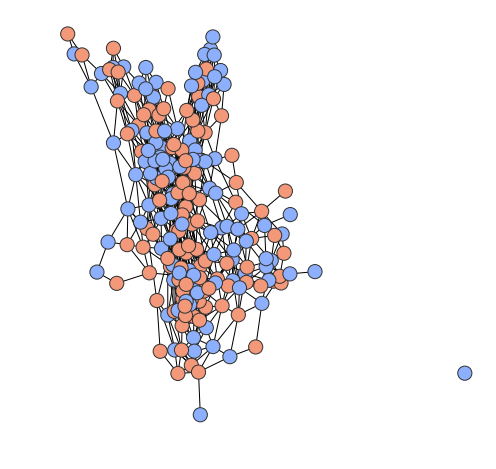

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
nx.draw_networkx(
    G,
    node_color=labels,
    with_labels=False,
    cmap="coolwarm",
    vmin=-0.5, vmax=1.5,
    node_size=200,
    ax=ax)
ax.collections[0].set_edgecolor("0.2") 
fig.savefig("../figures/gpt2-gutenberg-primmed-network.png", dpi=300)

In [ ]:
! mkdir ../figures